In [1]:
from google.cloud import bigquery

In [2]:
client=bigquery.Client()

C:\ProgramData\Anaconda3\lib\site-packages\google\auth\_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
%load_ext google.cloud.bigquery

In [4]:
%reload_ext google.cloud.bigquery

In [5]:
#######################################
print('Setting everything up...')
#######################################

import warnings
warnings.filterwarnings('ignore')
import pandas_gbq 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D

import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline



import os
import sys
from datetime import datetime
from datetime import date
from datetime import time
from datetime import timedelta
import time

DATASET = 'aou-res-curation-prod.prod_drc_dataset'

plt.style.use('ggplot')
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

from IPython.display import HTML as html_print

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)


print('done.')


Setting everything up...
done.


In [6]:
dic={'src_hpo_id':["seec_miami","seec_morehouse","seec_emory","uamc_banner","pitt","nyc_cu","ipmc_uic","trans_am_spectrum","tach_hfhs","nec_bmc","cpmc_uci","nec_phs","nyc_cornell","ipmc_nu","nyc_hh","ipmc_uchicago","aouw_mcri","syhc","cpmc_ceders","seec_ufl","saou_uab","trans_am_baylor","cpmc_ucsd","ecchc","chci","aouw_uwh","cpmc_usc","hrhc","ipmc_northshore","chs","cpmc_ucsf","jhchc","aouw_mcw","cpmc_ucd","ipmc_rush"],
    'HPO':["SouthEast Enrollment Center Miami","SouthEast Enrollment Center Morehouse","SouthEast Enrollment Center Emory","Banner Health","University of Pittsburgh","Columbia University Medical Center","University of Illinois Chicago","Spectrum Health","Henry Ford Health System","Boston Medical Center","UC Irvine","Partners HealthCare","Weill Cornell Medical Center","Northwestern Memorial Hospital","Harlem Hospital","University of Chicago","Marshfield Clinic","San Ysidro Health Center","Cedars-Sinai","University of Florida","University of Alabama at Birmingham","Baylor","UC San Diego","Eau Claire Cooperative Health Center","Community Health Center, Inc.","UW Health (University of Wisconsin Madison)","University of Southern California","HRHCare","NorthShore University Health System","Cherokee Health Systems","UC San Francisco","Jackson-Hinds CHC","Medical College of Wisconsin","UC Davis","Rush University"]}


site_df=pd.DataFrame(data=dic)
site_df

,src_hpo_id,HPO
0,seec_miami,SouthEast Enrollment Center Miami
1,seec_morehouse,SouthEast Enrollment Center Morehouse
2,seec_emory,SouthEast Enrollment Center Emory
3,uamc_banner,Banner Health
4,pitt,University of Pittsburgh
5,nyc_cu,Columbia University Medical Center
6,ipmc_uic,University of Illinois Chicago
7,trans_am_spectrum,Spectrum Health
8,tach_hfhs,Henry Ford Health System
9,nec_bmc,Boston Medical Center


# All temporal data points should be consistent such that end dates should NOT be before a start date. 

## Visit Occurrence Table

In [7]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        COUNT(*) AS total,
        sum(case when (t1.visit_start_datetime>t1.visit_end_datetime) then 1 else 0 end) as wrong_date
    FROM
       `{}.unioned_ehr_visit_occurrence` AS t1

    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
1 records received.


In [8]:
temporal_df

,total,wrong_date
0,13057629,60131


### Visit Occurrence Table By Site

In [9]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        src_hpo_id,
        COUNT(*) AS total_rows,
        sum(case when (t1.visit_start_datetime>t1.visit_end_datetime) then 1 else 0 end) as wrong_date_rows
    FROM
       `{}.unioned_ehr_visit_occurrence` AS t1
    INNER JOIN
        (SELECT
            DISTINCT * 
        FROM
             `{}._mapping_visit_occurrence`)  AS t2
    ON
        t1.visit_occurrence_id=t2.visit_occurrence_id
    GROUP BY
        1
    ORDER BY
        3
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
32 records received.


In [10]:
temporal_df['succes_rate']=100-round(100*temporal_df['wrong_date_rows']/temporal_df['total_rows'],1)
temporal_df

,src_hpo_id,total_rows,wrong_date_rows,succes_rate
0,ipmc_rush,56208,0,100.0
1,chs,63840,0,100.0
2,trans_am_spectrum,152582,0,100.0
3,aouw_mcw,362780,0,100.0
4,ipmc_uic,327606,0,100.0
5,nec_bmc,547560,0,100.0
6,seec_emory,110137,0,100.0
7,syhc,78498,0,100.0
8,seec_ufl,105407,0,100.0
9,aouw_mcri,889744,0,100.0


In [11]:
visit_occurrence=temporal_df.rename(columns={"succes_rate":"visit_occurrence"})
visit_occurrence=visit_occurrence[["src_hpo_id","visit_occurrence"]]
visit_occurrence=visit_occurrence.fillna(100)
visit_occurrence

,src_hpo_id,visit_occurrence
0,ipmc_rush,100.0
1,chs,100.0
2,trans_am_spectrum,100.0
3,aouw_mcw,100.0
4,ipmc_uic,100.0
5,nec_bmc,100.0
6,seec_emory,100.0
7,syhc,100.0
8,seec_ufl,100.0
9,aouw_mcri,100.0


In [12]:
total_wrong=temporal_df['wrong_date_rows'].sum()
total_wrong

60131

In [13]:
total_row=temporal_df['total_rows'].sum()
percent=round(100-100*(total_wrong/(total_row)),1)
percent

99.5

## Condition Occurrence Table

In [14]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        COUNT(*) AS total,
        sum(case when (t1.condition_start_datetime>t1.condition_end_datetime) then 1 else 0 end) as wrong_date
    FROM
       `{}.unioned_ehr_condition_occurrence` AS t1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
1 records received.


In [15]:
temporal_df

,total,wrong_date
0,28412211,89


In [16]:
print("success rate for condition_occurrence is: ",round(100-100*(temporal_df.iloc[0,1]/temporal_df.iloc[0,0]),1))

success rate for condition_occurrence is:  100.0


### Condition Occurrence Table By Site

In [17]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        src_hpo_id,
        COUNT(*) AS total_rows,
        sum(case when (t1.condition_start_datetime>t1.condition_end_datetime) then 1 else 0 end) as wrong_date_rows
    FROM
       `{}.unioned_ehr_condition_occurrence` AS t1
    INNER JOIN
        (SELECT
            DISTINCT * 
        FROM
             `{}._mapping_condition_occurrence`)  AS t2
    ON
        t1.condition_occurrence_id=t2.condition_occurrence_id
    GROUP BY
        1
    ORDER BY
        3
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
32 records received.


In [18]:
temporal_df['succes_rate']=100-round(100*temporal_df['wrong_date_rows']/temporal_df['total_rows'],1)
temporal_df

,src_hpo_id,total_rows,wrong_date_rows,succes_rate
0,nyc_cu,2086163,0,100.0
1,hrhc,33351,0,100.0
2,cpmc_ucd,771216,0,100.0
3,seec_emory,122724,0,100.0
4,seec_morehouse,21759,0,100.0
5,cpmc_ceders,239722,0,100.0
6,cpmc_usc,303487,0,100.0
7,nec_bmc,615335,0,100.0
8,nec_phs,3500964,0,100.0
9,cpmc_ucsd,238962,0,100.0


In [19]:
condition_occurrence=temporal_df.rename(columns={"succes_rate":"condition_occurrence"})
condition_occurrence=condition_occurrence[["src_hpo_id","condition_occurrence"]]
condition_occurrence=condition_occurrence.fillna(100)
condition_occurrence

,src_hpo_id,condition_occurrence
0,nyc_cu,100.0
1,hrhc,100.0
2,cpmc_ucd,100.0
3,seec_emory,100.0
4,seec_morehouse,100.0
5,cpmc_ceders,100.0
6,cpmc_usc,100.0
7,nec_bmc,100.0
8,nec_phs,100.0
9,cpmc_ucsd,100.0


In [20]:
total_wrong=temporal_df['wrong_date_rows'].sum()
total_wrong

89

In [21]:
total_row=temporal_df['total_rows'].sum()
percent=round(100-100*(total_wrong/(total_row)),1)
percent

100.0

## Drug Exposure Table

In [22]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        COUNT(*) AS total,
        sum(case when (t1.drug_exposure_start_datetime>t1.drug_exposure_end_datetime) then 1 else 0 end) as wrong_date
    FROM
       `{}.unioned_ehr_drug_exposure` AS t1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
1 records received.


In [23]:
temporal_df

,total,wrong_date
0,14364734,559701


In [24]:
print("success rate for drug_exposure is: ",round(100-100*(temporal_df.iloc[0,1]/temporal_df.iloc[0,0]),1))

success rate for drug_exposure is:  96.1


### Drug Exposure Table By Site

In [25]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        src_hpo_id,
        COUNT(*) AS total_rows,
        sum(case when (t1.drug_exposure_start_datetime>t1.drug_exposure_end_datetime) then 1 else 0 end) as wrong_date_rows
    FROM
       `{}.unioned_ehr_drug_exposure` AS t1
    INNER JOIN
        (SELECT
            DISTINCT * 
        FROM
             `{}._mapping_drug_exposure`)  AS t2
    ON
        t1.drug_exposure_id=t2.drug_exposure_id
    GROUP BY
        1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
33 records received.


In [26]:
temporal_df['succes_rate']=100-round(100*temporal_df['wrong_date_rows']/temporal_df['total_rows'],1)
temporal_df

,src_hpo_id,total_rows,wrong_date_rows,succes_rate
0,nyc_cu,1260521,0,100.0
1,ipmc_northshore,54763,654,98.8
2,pitt,2938146,0,100.0
3,aouw_uwh,417048,47140,88.7
4,ecchc,21735,0,100.0
5,nec_bmc,53890,0,100.0
6,ipmc_nu,763034,0,100.0
7,seec_morehouse,90636,0,100.0
8,cpmc_usc,115453,70,99.9
9,cpmc_ucsf,416733,0,100.0


In [27]:
drug_exposure=temporal_df.rename(columns={"succes_rate":"drug_exposure"})
drug_exposure=drug_exposure[["src_hpo_id","drug_exposure"]]
drug_exposure=drug_exposure.fillna(100)
drug_exposure

,src_hpo_id,drug_exposure
0,nyc_cu,100.0
1,ipmc_northshore,98.8
2,pitt,100.0
3,aouw_uwh,88.7
4,ecchc,100.0
5,nec_bmc,100.0
6,ipmc_nu,100.0
7,seec_morehouse,100.0
8,cpmc_usc,99.9
9,cpmc_ucsf,100.0


In [28]:
total_wrong=temporal_df['wrong_date_rows'].sum()
total_wrong

559701

In [29]:
total_row=temporal_df['total_rows'].sum()
percent=round(100-100*(total_wrong/(total_row)),1)
percent

96.1

## Device Exposure Table

In [30]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        COUNT(*) AS total,
        sum(case when (t1.device_exposure_start_datetime>t1.device_exposure_end_datetime) then 1 else 0 end) as wrong_date
    FROM
       `{}.unioned_ehr_device_exposure` AS t1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
1 records received.


In [31]:
temporal_df

,total,wrong_date
0,1530784,3471


In [32]:
print("success rate for device is: ",round(100-100*(temporal_df.iloc[0,1]/temporal_df.iloc[0,0]),1))

success rate for device is:  99.8


### Device Exposure Table By Site

In [33]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        src_hpo_id,
        COUNT(*) AS total_rows,
        sum(case when (t1.device_exposure_start_datetime>t1.device_exposure_end_datetime) then 1 else 0 end) as wrong_date_rows
    FROM
       `{}.unioned_ehr_device_exposure` AS t1
    INNER JOIN
        (SELECT
            DISTINCT * 
        FROM
             `{}._mapping_device_exposure`)  AS t2
    ON
        t1.device_exposure_id=t2.device_exposure_id
    GROUP BY
        1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
21 records received.


In [34]:
temporal_df['succes_rate']=100-round(100*temporal_df['wrong_date_rows']/temporal_df['total_rows'],1)
temporal_df

,src_hpo_id,total_rows,wrong_date_rows,succes_rate
0,ipmc_uic,10371,0,100.0
1,seec_miami,4592,0,100.0
2,syhc,256,0,100.0
3,trans_am_spectrum,271,0,100.0
4,hrhc,47,0,100.0
5,jhchc,569,0,100.0
6,nyc_cornell,1944,0,100.0
7,nyc_cu,4395,44,99.0
8,pitt,12154,0,100.0
9,cpmc_usc,34,0,100.0


In [35]:
device_exposure=temporal_df.rename(columns={"succes_rate":"device_exposure"})
device_exposure=device_exposure[["src_hpo_id","device_exposure"]]
device_exposure=device_exposure.fillna(100)
device_exposure

,src_hpo_id,device_exposure
0,ipmc_uic,100.0
1,seec_miami,100.0
2,syhc,100.0
3,trans_am_spectrum,100.0
4,hrhc,100.0
5,jhchc,100.0
6,nyc_cornell,100.0
7,nyc_cu,99.0
8,pitt,100.0
9,cpmc_usc,100.0


In [36]:
total_wrong=temporal_df['wrong_date_rows'].sum()
total_wrong

3471

In [37]:
total_row=temporal_df['total_rows'].sum()
percent=round(100-100*(total_wrong/(total_row)),1)
percent

99.8

In [38]:
temporal_df

,src_hpo_id,total_rows,wrong_date_rows,succes_rate
0,ipmc_uic,10371,0,100.0
1,seec_miami,4592,0,100.0
2,syhc,256,0,100.0
3,trans_am_spectrum,271,0,100.0
4,hrhc,47,0,100.0
5,jhchc,569,0,100.0
6,nyc_cornell,1944,0,100.0
7,nyc_cu,4395,44,99.0
8,pitt,12154,0,100.0
9,cpmc_usc,34,0,100.0


## Temporal Data Points - End Dates Before Start Dates

In [39]:

succes_rate=pd.merge(visit_occurrence,condition_occurrence,how='outer',on='src_hpo_id')
succes_rate=pd.merge(succes_rate,drug_exposure,how='outer',on='src_hpo_id')
succes_rate=pd.merge(succes_rate,device_exposure,how='outer',on='src_hpo_id')
succes_rate=pd.merge(succes_rate,site_df,how='outer',on='src_hpo_id')
succes_rate=succes_rate.fillna("No Data")
succes_rate

,src_hpo_id,visit_occurrence,condition_occurrence,drug_exposure,device_exposure,HPO
0,ipmc_rush,100,100,69.4,No Data,Rush University
1,chs,100,100,100,100,Cherokee Health Systems
2,trans_am_spectrum,100,100,100,100,Spectrum Health
3,aouw_mcw,100,99.6,100,100,Medical College of Wisconsin
4,ipmc_uic,100,No Data,100,100,University of Illinois Chicago
5,nec_bmc,100,100,100,No Data,Boston Medical Center
6,seec_emory,100,100,100,No Data,SouthEast Enrollment Center Emory
7,syhc,100,100,100,100,San Ysidro Health Center
8,seec_ufl,100,100,100,No Data,University of Florida
9,aouw_mcri,100,100,100,100,Marshfield Clinic


In [40]:
succes_rate.to_csv("data\\end_before_begin.csv")

# No data point exists beyond 30 days of the death date. (Achilles rule_id #3)

## Visit Occurrence Table

In [41]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        src_hpo_id,
        COUNT(*) AS total,
        sum(case when (DATE_DIFF(visit_start_date, death_date, DAY)>30) then 1 else 0 end) as wrong_death_date
    FROM
       `{}.unioned_ehr_visit_occurrence` AS t1
    INNER JOIN
        `{}.unioned_ehr_death` AS t2
        ON
            t1.person_id=t2.person_id
    INNER JOIN
        (SELECT
            DISTINCT * 
        FROM
             `{}._mapping_visit_occurrence`)  AS t3
    ON
        t1.visit_occurrence_id=t3.visit_occurrence_id
    GROUP BY
        1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
19 records received.


In [42]:
temporal_df['succes_rate']=100-round(100*temporal_df['wrong_death_date']/temporal_df['total'],1)
temporal_df

,src_hpo_id,total,wrong_death_date,succes_rate
0,chs,116,0,100.0
1,chci,405,0,100.0
2,pitt,3637,0,100.0
3,ecchc,36,0,100.0
4,nyc_cu,3419,221,93.5
5,ipmc_nu,3317,5,99.8
6,aouw_mcw,4553,0,100.0
7,aouw_uwh,869,0,100.0
8,cpmc_uci,4870,0,100.0
9,ipmc_uic,2771,1,100.0


- main reason death date entered as default value ("1890")

In [43]:
visit_occurrence=temporal_df.rename(columns={"succes_rate":"visit_occurrence"})
visit_occurrence=visit_occurrence[["src_hpo_id","visit_occurrence"]]
visit_occurrence=visit_occurrence.fillna(100)
visit_occurrence

,src_hpo_id,visit_occurrence
0,chs,100.0
1,chci,100.0
2,pitt,100.0
3,ecchc,100.0
4,nyc_cu,93.5
5,ipmc_nu,99.8
6,aouw_mcw,100.0
7,aouw_uwh,100.0
8,cpmc_uci,100.0
9,ipmc_uic,100.0


## Condition Occurrence Table

In [44]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        src_hpo_id,
        COUNT(*) AS total,
        sum(case when (DATE_DIFF(condition_start_date, death_date, DAY)>30) then 1 else 0 end) as wrong_death_date
    FROM
       `{}.unioned_ehr_condition_occurrence` AS t1
    INNER JOIN
        `{}.unioned_ehr_death` AS t2
        ON
            t1.person_id=t2.person_id
    INNER JOIN
        (SELECT
            DISTINCT * 
        FROM
             `{}._mapping_condition_occurrence`)  AS t3
    ON
        t1.condition_occurrence_id=t3.condition_occurrence_id
    GROUP BY
        1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
19 records received.


In [45]:
temporal_df['succes_rate']=100-round(100*temporal_df['wrong_death_date']/temporal_df['total'],1)
temporal_df

,src_hpo_id,total,wrong_death_date,succes_rate
0,cpmc_uci,18009,0,100.0
1,aouw_uwh,26288,0,100.0
2,tach_hfhs,14853,0,100.0
3,nyc_cornell,1408,0,100.0
4,nyc_cu,14899,839,94.4
5,pitt,8122,2,100.0
6,ipmc_nu,5040,0,100.0
7,aouw_mcri,12806,0,100.0
8,cpmc_ceders,667,0,100.0
9,ecchc,168,0,100.0


In [46]:
condition_occurrence=temporal_df.rename(columns={"succes_rate":"condition_occurrence"})
condition_occurrence=condition_occurrence[["src_hpo_id","condition_occurrence"]]
condition_occurrence=condition_occurrence.fillna(100)
condition_occurrence

,src_hpo_id,condition_occurrence
0,cpmc_uci,100.0
1,aouw_uwh,100.0
2,tach_hfhs,100.0
3,nyc_cornell,100.0
4,nyc_cu,94.4
5,pitt,100.0
6,ipmc_nu,100.0
7,aouw_mcri,100.0
8,cpmc_ceders,100.0
9,ecchc,100.0


## Drug Exposure Table

In [47]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        src_hpo_id,
        COUNT(*) AS total,
        sum(case when (DATE_DIFF(drug_exposure_start_date, death_date, DAY)>30) then 1 else 0 end) as wrong_death_date
    FROM
       `{}.unioned_ehr_drug_exposure` AS t1
    INNER JOIN
        `{}.unioned_ehr_death` AS t2
        ON
            t1.person_id=t2.person_id
    INNER JOIN
        (SELECT
            DISTINCT * 
        FROM
             `{}._mapping_drug_exposure`)  AS t3
    ON
        t1.drug_exposure_id=t3.drug_exposure_id
    GROUP BY
        1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
20 records received.


In [48]:
temporal_df['succes_rate']=100-round(100*temporal_df['wrong_death_date']/temporal_df['total'],1)
temporal_df

,src_hpo_id,total,wrong_death_date,succes_rate
0,ipmc_uic,21486,0,100.0
1,aouw_mcw,4009,0,100.0
2,cpmc_ucsd,993,0,100.0
3,nyc_cu,12528,609,95.1
4,pitt,10854,1,100.0
5,saou_uab,1626,0,100.0
6,nyc_cornell,4277,0,100.0
7,tach_hfhs,15040,0,100.0
8,cpmc_uci,29568,0,100.0
9,aouw_uwh,1887,0,100.0


In [49]:
drug_exposure=temporal_df.rename(columns={"succes_rate":"drug_exposure"})
drug_exposure=drug_exposure[["src_hpo_id","drug_exposure"]]
drug_exposure=drug_exposure.fillna(100)
drug_exposure

,src_hpo_id,drug_exposure
0,ipmc_uic,100.0
1,aouw_mcw,100.0
2,cpmc_ucsd,100.0
3,nyc_cu,95.1
4,pitt,100.0
5,saou_uab,100.0
6,nyc_cornell,100.0
7,tach_hfhs,100.0
8,cpmc_uci,100.0
9,aouw_uwh,100.0


## Measurement Table

In [50]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        src_hpo_id,
        COUNT(*) AS total,
        sum(case when (DATE_DIFF(measurement_date, death_date, DAY)>30) then 1 else 0 end) as wrong_death_date
    FROM
       `{}.unioned_ehr_measurement` AS t1
    INNER JOIN
        `{}.unioned_ehr_death` AS t2
        ON
            t1.person_id=t2.person_id
    INNER JOIN
        (SELECT
            DISTINCT * 
        FROM
             `{}._mapping_measurement`)  AS t3
    ON
        t1.measurement_id=t3.measurement_id
    GROUP BY
        1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
19 records received.


In [51]:
temporal_df['succes_rate']=100-round(100*temporal_df['wrong_death_date']/temporal_df['total'],1)
temporal_df

,src_hpo_id,total,wrong_death_date,succes_rate
0,pitt,64761,0,100.0
1,tach_hfhs,86212,0,100.0
2,uamc_banner,65912,37789,42.7
3,cpmc_uci,138390,5,100.0
4,chci,1626,0,100.0
5,ipmc_nu,18076,0,100.0
6,nyc_cu,187594,18130,90.3
7,aouw_uwh,2152,0,100.0
8,saou_uab,10771,0,100.0
9,aouw_mcw,20073,0,100.0


In [52]:
measurement=temporal_df.rename(columns={"succes_rate":"measurement"})
measurement=measurement[["src_hpo_id","measurement"]]
measurement=measurement.fillna(100)
measurement

,src_hpo_id,measurement
0,pitt,100.0
1,tach_hfhs,100.0
2,uamc_banner,42.7
3,cpmc_uci,100.0
4,chci,100.0
5,ipmc_nu,100.0
6,nyc_cu,90.3
7,aouw_uwh,100.0
8,saou_uab,100.0
9,aouw_mcw,100.0


## Procedure Occurrence Table

In [53]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        src_hpo_id,
        COUNT(*) AS total,
        sum(case when (DATE_DIFF(procedure_date, death_date, DAY)>30) then 1 else 0 end) as wrong_death_date
    FROM
       `{}.unioned_ehr_procedure_occurrence` AS t1
    INNER JOIN
        `{}.unioned_ehr_death` AS t2
        ON
            t1.person_id=t2.person_id
    INNER JOIN
        (SELECT
            DISTINCT * 
        FROM
             `{}._mapping_procedure_occurrence`)  AS t3
    ON
        t1.procedure_occurrence_id=t3.procedure_occurrence_id
    GROUP BY
        1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
18 records received.


In [54]:
temporal_df['succes_rate']=100-round(100*temporal_df['wrong_death_date']/temporal_df['total'],1)
temporal_df

,src_hpo_id,total,wrong_death_date,succes_rate
0,aouw_mcw,4140,0,100.0
1,aouw_uwh,682,0,100.0
2,chs,164,0,100.0
3,chci,402,0,100.0
4,pitt,2971,0,100.0
5,cpmc_uci,17072,1,100.0
6,nyc_cu,5536,304,94.5
7,ipmc_nu,885,0,100.0
8,ipmc_uic,5426,0,100.0
9,saou_uab,214,0,100.0


In [55]:
procedure_occurrence=temporal_df.rename(columns={"succes_rate":"procedure_occurrence"})
procedure_occurrence=procedure_occurrence[["src_hpo_id","procedure_occurrence"]]
procedure_occurrence=procedure_occurrence.fillna(100)
procedure_occurrence

,src_hpo_id,procedure_occurrence
0,aouw_mcw,100.0
1,aouw_uwh,100.0
2,chs,100.0
3,chci,100.0
4,pitt,100.0
5,cpmc_uci,100.0
6,nyc_cu,94.5
7,ipmc_nu,100.0
8,ipmc_uic,100.0
9,saou_uab,100.0


## Observation Table

In [56]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        src_hpo_id,
        COUNT(*) AS total,
        sum(case when (DATE_DIFF(observation_date, death_date, DAY)>30) then 1 else 0 end) as wrong_death_date
    FROM
       `{}.unioned_ehr_observation` AS t1
    INNER JOIN
        `{}.unioned_ehr_death` AS t2
        ON
            t1.person_id=t2.person_id
    INNER JOIN
        (SELECT
            DISTINCT * 
        FROM
             `{}._mapping_observation`)  AS t3
    ON
        t1.observation_id=t3.observation_id
    GROUP BY
        1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
21 records received.


In [57]:
temporal_df['succes_rate']=100-round(100*temporal_df['wrong_death_date']/temporal_df['total'],1)
temporal_df

,src_hpo_id,total,wrong_death_date,succes_rate
0,chs,40,0,100.0
1,pitt,1564,2,99.9
2,nyc_cu,1869,84,95.5
3,ipmc_nu,304,0,100.0
4,aouw_mcw,601,0,100.0
5,aouw_uwh,1101,2,99.8
6,cpmc_uci,15516,0,100.0
7,saou_uab,1476,0,100.0
8,aouw_mcri,7253,0,100.0
9,cpmc_ucsd,156,0,100.0


In [58]:
observation=temporal_df.rename(columns={"succes_rate":"observation"})
observation=observation[["src_hpo_id","observation"]]
observation=observation.fillna(100)
observation

,src_hpo_id,observation
0,chs,100.0
1,pitt,99.9
2,nyc_cu,95.5
3,ipmc_nu,100.0
4,aouw_mcw,100.0
5,aouw_uwh,99.8
6,cpmc_uci,100.0
7,saou_uab,100.0
8,aouw_mcri,100.0
9,cpmc_ucsd,100.0


## Device Exposure Table

In [59]:
######################################
print('Getting the data from the database...')
######################################

temporal_df = pd.io.gbq.read_gbq('''
    SELECT
        src_hpo_id,
        COUNT(*) AS total,
        sum(case when (DATE_DIFF(device_exposure_start_date, death_date, DAY)>30) then 1 else 0 end) as wrong_death_date
    FROM
       `{}.unioned_ehr_device_exposure` AS t1
    INNER JOIN
        `{}.unioned_ehr_death` AS t2
        ON
            t1.person_id=t2.person_id
    INNER JOIN
        (SELECT
            DISTINCT * 
        FROM
             `{}._mapping_device_exposure`)  AS t3
    ON
        t1.device_exposure_id=t3.device_exposure_id
    GROUP BY
        1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
temporal_df.shape

print(temporal_df.shape[0], 'records received.')

Getting the data from the database...
11 records received.


In [60]:
temporal_df['succes_rate']=100-round(100*temporal_df['wrong_death_date']/temporal_df['total'],1)
temporal_df

,src_hpo_id,total,wrong_death_date,succes_rate
0,nyc_cu,218,10,95.4
1,trans_am_spectrum,6,0,100.0
2,aouw_mcw,1,0,100.0
3,pitt,32,0,100.0
4,aouw_uwh,54,0,100.0
5,ipmc_uic,122,0,100.0
6,saou_uab,120,0,100.0
7,aouw_mcri,183,0,100.0
8,tach_hfhs,582,0,100.0
9,uamc_banner,179,140,21.8


In [61]:
device_exposure=temporal_df.rename(columns={"succes_rate":"device_exposure"})
device_exposure=device_exposure[["src_hpo_id","device_exposure"]]
device_exposure=device_exposure.fillna(100)
device_exposure

,src_hpo_id,device_exposure
0,nyc_cu,95.4
1,trans_am_spectrum,100.0
2,aouw_mcw,100.0
3,pitt,100.0
4,aouw_uwh,100.0
5,ipmc_uic,100.0
6,saou_uab,100.0
7,aouw_mcri,100.0
8,tach_hfhs,100.0
9,uamc_banner,21.8


## 4. Succes Rate Temporal Data Points - Data After Death Date

In [62]:
datas=[
       condition_occurrence,drug_exposure
       ,measurement,procedure_occurrence,observation,device_exposure
]

In [63]:
master_df=visit_occurrence

In [64]:
for filename in datas:
    master_df = pd.merge(master_df,filename,on='src_hpo_id',how='outer')

In [65]:
master_df

,src_hpo_id,visit_occurrence,condition_occurrence,drug_exposure,measurement,procedure_occurrence,observation,device_exposure
0,chs,100.0,100.0,100.0,100.0,100.0,100.0,NaN
1,chci,100.0,100.0,100.0,100.0,100.0,100.0,NaN
2,pitt,100.0,100.0,100.0,100.0,100.0,99.9,100.0
3,ecchc,100.0,100.0,100.0,100.0,NaN,100.0,NaN
4,nyc_cu,93.5,94.4,95.1,90.3,94.5,95.5,95.4
5,ipmc_nu,99.8,100.0,100.0,100.0,100.0,100.0,NaN
6,aouw_mcw,100.0,100.0,100.0,100.0,100.0,100.0,100.0
7,aouw_uwh,100.0,100.0,100.0,100.0,100.0,99.8,100.0
8,cpmc_uci,100.0,100.0,100.0,100.0,100.0,100.0,NaN
9,ipmc_uic,100.0,NaN,100.0,100.0,100.0,100.0,100.0


In [66]:
succes_rate=pd.merge(master_df,site_df,how='outer',on='src_hpo_id')
succes_rate=succes_rate.fillna("No Data")

In [67]:
succes_rate.to_csv("data\\data_after_date.csv")

# Age of participant should NOT be below 18 and should NOT be too high (Achilles rule_id #20 and 21)

## Count number of unique participants with age <18 

In [68]:


######################################
print('Getting the data from the database...')
######################################

birth_df = pd.io.gbq.read_gbq('''
    SELECT
        COUNT(*) AS total,
        sum(case when (DATE_DIFF(CURRENT_DATE, EXTRACT(DATE FROM birth_datetime), YEAR)<18) then 1 else 0 end) as wrong_death_date
         
    FROM
       `{}.unioned_ehr_person` AS t1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
print(birth_df.shape[0], 'records received.')

Getting the data from the database...
1 records received.


In [69]:
birth_df

,total,wrong_death_date
0,109661,1


## Count number of unique participants with age >120

In [70]:

######################################
print('Getting the data from the database...')
######################################

birth_df = pd.io.gbq.read_gbq('''
    SELECT
        COUNT(*) AS total,
        sum(case when (DATE_DIFF(CURRENT_DATE, EXTRACT(DATE FROM birth_datetime), YEAR)>120) then 1 else 0 end) as wrong_death_date
         
    FROM
       `{}.unioned_ehr_person` AS t1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
print(birth_df.shape[0], 'records received.')

Getting the data from the database...
1 records received.


In [71]:
birth_df

,total,wrong_death_date
0,109661,0


## Histogram

In [72]:


######################################
print('Getting the data from the database...')
######################################

birth_df = pd.io.gbq.read_gbq('''
    SELECT
        DATE_DIFF(CURRENT_DATE, EXTRACT(DATE FROM birth_datetime), YEAR) as AGE    
    FROM
       `{}.unioned_ehr_person` AS t1
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
print(birth_df.shape[0], 'records received.')

Getting the data from the database...
109661 records received.


In [73]:
birth_df.head()

,AGE
0,84.0
1,83.0
2,82.0
3,19.0
4,90.0


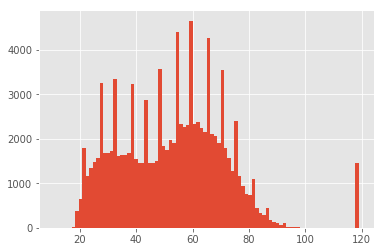

In [74]:
birth_df['AGE'].hist(bins=88)

# Participant should have supporting data in either lab results or drugs if he/she has a condition code for diabetes.

## T2D

In [75]:
######################################
print('Getting the data from the database...')
######################################

t2d_condition  = pd.io.gbq.read_gbq('''
        SELECT
            DISTINCT
            src_hpo_id,
            person_id,
            1 as t2d
        FROM
            `{}.concept` t1 
        INNER JOIN
            `{}.unioned_ehr_condition_occurrence` AS t2
        ON
            t1.concept_id=t2.condition_concept_id
        INNER JOIN
            (SELECT
                DISTINCT * 
            FROM 
                `{}._mapping_condition_occurrence`)  AS t3
        ON
            t3.condition_occurrence_id=t2.condition_occurrence_id
        WHERE concept_id in (4140466,43531588,45769888,45763582,37018912,43531578,
        43531559,43531566,43531653,43531577,43531562,37016163,45769894,45757474,
        37016768,4221495,43531616,43531564,443767,443733,43530689,4226121,36712686,
        36712687,43531608,43531597,443732,45757280,45769906,4177050,4223463,43530690,45769890,
        37018728,45772019,45769889,37016349,45770880,45757392,45771064,45757447,45757446,45757445,
        45757444,45757363,45772060,36714116,45769875,4130162,45771072,45770830,45769905,45757435,43531651,
        45770881,4222415,45769828,376065,45757450,45770883,45757255,37016354,43530656,45769836,443729,45757278,
        37017432,4063043,43531010,4129519,43530685,45770831,45757499,443731,45770928,45757075,45769872,45769835,
        36712670,46274058,4142579,45770832,45773064,201826,4230254,4304377,4321756,4196141,4099217,201530,4151282,
        4099216,4198296,4193704,4200875,4099651,45766052,40482801,45757277,45757449)
        and (invalid_reason is null or invalid_reason='')
        GROUP BY
            1,2
        ORDER BY
            1,2 desc
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
t2d_condition.shape



Getting the data from the database...


(12488, 3)

In [76]:
t2d_condition.head()

,src_hpo_id,person_id,t2d
0,aouw_mcri,993522873,1
1,aouw_mcri,992597659,1
2,aouw_mcri,991205505,1
3,aouw_mcri,990899474,1
4,aouw_mcri,987713484,1


## Drug

In [77]:
######################################
print('Getting the data from the database...')
######################################

drug  = pd.io.gbq.read_gbq('''
    SELECT
            DISTINCT
            src_hpo_id,
            person_id,
            1 as drug
        FROM
            `{}.concept`  AS t1
        INNER JOIN
            `{}.unioned_ehr_drug_exposure` AS t2
        ON
            t1.concept_id=t2.drug_concept_id
        INNER JOIN
            (SELECT
                DISTINCT * 
            FROM
                 `{}._mapping_drug_exposure`)  AS t3
        ON
            t3.drug_exposure_id=t2.drug_exposure_id
        WHERE concept_id in (1529331,1530014,1594973,1583722,1597756,1560171,19067100,1559684,1503297,1510202,1502826,
        1525215,1516766,1547504,1580747,1502809,1515249)and (invalid_reason is null or invalid_reason='')
    UNION DISTINCT 
        select 
            DISTINCT
            src_hpo_id,
            person_id,
            1 as drug
                FROM
                    `{}.concept`  AS t4
                INNER JOIN 
                    `{}.concept_ancestor` AS t5
                ON 
                    t4.concept_id = t5.descendant_concept_id
                INNER JOIN
                    `{}.unioned_ehr_drug_exposure` AS t6
                ON
                    t4.concept_id=t6.drug_concept_id
                INNER JOIN
                    (SELECT
                        DISTINCT * 
                    FROM
                         `{}._mapping_drug_exposure`)  AS t7
                ON
                    t7.drug_exposure_id=t6.drug_exposure_id
          and t5.ancestor_concept_id in (1529331,1530014,1594973,1583722,1597756,1560171,19067100,1559684,1503297,1510202,
          1502826,1525215,1516766,1547504,1580747,1502809,1515249)
          and (t4.invalid_reason is null or t4.invalid_reason='')
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET,DATASET,DATASET,DATASET,DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
drug.shape

Getting the data from the database...


(13131, 3)

In [78]:
drug.head(15)

,src_hpo_id,person_id,drug
0,uamc_banner,451257473,1
1,aouw_uwh,444020831,1
2,nec_phs,623916972,1
3,nec_phs,970922104,1
4,ipmc_uic,390050094,1
5,ipmc_uic,250518036,1
6,ipmc_uic,792309906,1
7,nec_phs,579353151,1
8,nec_phs,200719722,1
9,nec_phs,304719339,1


## glucose_lab

In [79]:
######################################
print('Getting the data from the database...')
######################################

glucose_lab = pd.io.gbq.read_gbq('''
    SELECT
            DISTINCT
            src_hpo_id,
            person_id,
            1 as drug
        FROM
            `{}.concept`  as t1
        INNER JOIN
            `{}.unioned_ehr_measurement` AS t2
        ON
            t1.concept_id=t2.measurement_concept_id
        INNER JOIN
            (SELECT
                DISTINCT * 
            FROM
                 `{}._mapping_measurement`)  AS t3
        ON
            t2.measurement_id=t3.measurement_id
        WHERE 
            concept_id in (3004501,3000483) and (invalid_reason is null or invalid_reason='')

    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
glucose_lab.shape

Getting the data from the database...


(66985, 3)

In [80]:
glucose_lab.head()

,src_hpo_id,person_id,drug
0,seec_morehouse,918774119,1
1,seec_morehouse,398492106,1
2,chs,526616487,1
3,seec_morehouse,568419241,1
4,seec_morehouse,472811838,1



-glucose lab may not be a got clasifier

## fasting_glucose

In [81]:
######################################
print('Getting the data from the database...')
######################################

fasting_glucose = pd.io.gbq.read_gbq('''
    SELECT
            DISTINCT
            src_hpo_id,
            person_id,
            1 as drug
        FROM
            `{}.concept`  as t1
        INNER JOIN
            `{}.unioned_ehr_measurement` AS t2
        ON
            t1.concept_id=t2.measurement_concept_id
        INNER JOIN
            (SELECT
                DISTINCT * 
            FROM
                 `{}._mapping_measurement`)  AS t3
        ON
            t2.measurement_id=t3.measurement_id
        WHERE
            concept_id  in (3037110) and (invalid_reason is null or invalid_reason='')

    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
fasting_glucose.shape

Getting the data from the database...


(4558, 3)

In [82]:
fasting_glucose.head()

,src_hpo_id,person_id,drug
0,cpmc_ucsf,1428076,1
1,nyc_cornell,226818204,1
2,chs,891292955,1
3,chs,246386688,1
4,nyc_cu,901610059,1


## a1c

In [83]:
######################################
print('Getting the data from the database...')
######################################

a1c = pd.io.gbq.read_gbq('''
    SELECT
            DISTINCT
            src_hpo_id,
            person_id,
            1 as drug
        FROM
            `{}.concept`  as t1
        INNER JOIN
            `{}.unioned_ehr_measurement` AS t2
        ON
            t1.concept_id=t2.measurement_concept_id
        INNER JOIN
            (SELECT
                DISTINCT * 
            FROM
                 `{}._mapping_measurement`)  AS t3
        ON
            t2.measurement_id=t3.measurement_id
        WHERE concept_id  in (3004410,3007263,3003309,3005673) and (invalid_reason is null or invalid_reason='')

    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
a1c.shape

Getting the data from the database...


(39751, 3)

In [84]:
a1c.head()

,src_hpo_id,person_id,drug
0,aouw_uwh,245472181,1
1,aouw_uwh,576322822,1
2,aouw_uwh,842515824,1
3,aouw_uwh,184873403,1
4,nyc_hh,194232731,1


## t1d_condition

In [85]:

######################################
print('Getting the data from the database...')
######################################

t1d_condition = pd.io.gbq.read_gbq('''
    SELECT
            DISTINCT
            src_hpo_id,
            person_id,
            1 as t1d
        FROM
            `{}.concept` t1 
        INNER JOIN
            `{}.unioned_ehr_condition_occurrence` AS t2
        ON
            t1.concept_id=t2.condition_concept_id
        INNER JOIN
            (SELECT
                DISTINCT * 
            FROM 
                `{}._mapping_condition_occurrence`)  AS t3
        ON
            t3.condition_occurrence_id=t2.condition_occurrence_id
        WHERE concept_id  in (36715571,4143857,45769891,45763585,45773688,45773576,45769901,45771075,45769902,45769903,45769837,
        45757674,37016767,4225656,45769832,43531565,373999,4227210,45757074,435216,37016353,45769904,45757507,45769892,37017429,
        45771068,37016348,45757432,443592,45757393,45771067,45769876,4228112,45757362,4047906,4102018,36717215,439770,4224254,
        45757535,37016179,43530660,37016180,4225055,4224709,45769829,377821,45769830,45763583,45769834,36713094,318712,37018566,
        4222687,4222553,37017431,4063042,43531008,43531009,45763584,45757604,200687,45757266,45757073,45771533,45773567,
        45769833,46269764,4143689,45769873,201254,4099215,40484648,4152858,4096668,201531,4151281,443412,4295011,4099214,
        45766051,45770902) 
        and (invalid_reason is null or invalid_reason='')

    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
t1d_condition.shape

Getting the data from the database...


(2264, 3)

In [86]:
t1d_condition.head()

,src_hpo_id,person_id,t1d
0,pitt,380644311,1
1,aouw_mcri,940757898,1
2,nyc_cornell,409094825,1
3,aouw_uwh,499282574,1
4,nec_phs,627909334,1


## insulin

In [87]:
######################################
print('Getting the data from the database...')
######################################

insulin  = pd.io.gbq.read_gbq('''
    SELECT
            DISTINCT
            src_hpo_id,
            person_id,
            1 as insulin
        FROM
            `{}.concept`  AS t1
        INNER JOIN
            `{}.unioned_ehr_drug_exposure` AS t2
        ON
            t1.concept_id=t2.drug_concept_id
        INNER JOIN
            (SELECT
                DISTINCT * 
            FROM
                 `{}._mapping_drug_exposure`)  AS t3
        ON
            t3.drug_exposure_id=t2.drug_exposure_id
        WHERE t1.concept_id in (19122121,1567198,1531601,1516976,1502905,1544838,1550023,1513876,1517998) 
        and (t1.invalid_reason is null or t1.invalid_reason='')
    UNION DISTINCT 
        SELECT 
            DISTINCT
            src_hpo_id,
            person_id,
            1 as drug
                FROM
                    `{}.concept`  AS t4
                INNER JOIN 
                    `{}.concept_ancestor` AS t5
                ON 
                    t4.concept_id = t5.descendant_concept_id
                INNER JOIN
                    `{}.unioned_ehr_drug_exposure` AS t6
                ON
                    t4.concept_id=t6.drug_concept_id
                INNER JOIN
                    (SELECT
                        DISTINCT * 
                    FROM
                         `{}._mapping_drug_exposure`)  AS t7
                ON
                    t7.drug_exposure_id=t6.drug_exposure_id
          and t5.ancestor_concept_id in (19122121,1567198,1531601,1516976,1502905,1544838,1550023,1513876,1517998)
          and (t4.invalid_reason is null or t4.invalid_reason='')
    '''.format(DATASET, DATASET,DATASET,DATASET,DATASET,DATASET, DATASET,DATASET,DATASET,DATASET,DATASET, DATASET,DATASET,DATASET,DATASET,DATASET),
                    dialect='standard')
insulin.shape

Getting the data from the database...


(10134, 3)

In [88]:
insulin.head(15)


,src_hpo_id,person_id,insulin
0,ipmc_uic,710671785,1
1,uamc_banner,885364677,1
2,uamc_banner,304469283,1
3,uamc_banner,995245924,1
4,ipmc_uic,817811422,1
5,ipmc_uic,951267466,1
6,ipmc_uic,110174005,1
7,saou_uab,995905947,1
8,saou_uab,378023450,1
9,saou_uab,123902403,1


In [89]:
diabet=pd.merge(t2d_condition,t1d_condition,on=["src_hpo_id","person_id"],how="outer")
diabet["diabetes"]=1

In [90]:
diabet=diabet.loc[:,["src_hpo_id","person_id","diabetes"]]
diabet.shape

(12780, 3)

In [91]:
diabet.head()

,src_hpo_id,person_id,diabetes
0,aouw_mcri,993522873,1
1,aouw_mcri,992597659,1
2,aouw_mcri,991205505,1
3,aouw_mcri,990899474,1
4,aouw_mcri,987713484,1


In [92]:
total_diab=diabet.drop_duplicates(keep=False, inplace=False)
total_diab.shape

(12780, 3)

In [93]:
total_diab=total_diab.groupby(["src_hpo_id"]).size().reset_index().rename(columns={0:'total_diabetes'}).sort_values(["total_diabetes"])
total_diab

,src_hpo_id,total_diabetes
21,saou_uab,7
29,uamc_banner,9
24,seec_morehouse,29
13,ipmc_rush,60
2,aouw_uwh,94
11,ipmc_northshore,106
19,nyc_hh,126
1,aouw_mcw,127
10,hrhc,128
5,cpmc_ceders,141


In [94]:
test=pd.merge(drug,glucose_lab,on=["src_hpo_id","person_id"],how="outer")
test=pd.merge(test,fasting_glucose,on=["src_hpo_id","person_id"],how="outer")
test=pd.merge(test,a1c,on=["src_hpo_id","person_id"],how="outer")
test=pd.merge(test,insulin,on=["src_hpo_id","person_id"],how="outer")
test["tests"]=1

In [95]:
test=test.loc[:,["src_hpo_id","person_id","tests"]]
test.shape

(72594, 3)

In [96]:
test.head()

,src_hpo_id,person_id,tests
0,uamc_banner,451257473,1
1,aouw_uwh,444020831,1
2,nec_phs,623916972,1
3,nec_phs,970922104,1
4,ipmc_uic,390050094,1


In [97]:
total_test=test.drop_duplicates(keep=False, inplace=False)
total_test.shape

(72594, 3)

In [98]:
total_test=total_test.groupby(["src_hpo_id"]).size().reset_index().rename(columns={0:'total_diabetes'}).sort_values(["total_diabetes"])
total_test

,src_hpo_id,total_diabetes
22,nyc_hh,65
17,jhchc,263
18,nec_bmc,269
15,ipmc_rush,335
27,seec_morehouse,353
0,aouw_mcri,397
9,cpmc_ucsf,504
2,aouw_uwh,591
12,hrhc,639
13,ipmc_northshore,660


In [99]:
diabetes_and_test=pd.merge(test,diabet,on=["src_hpo_id","person_id"],how="outer")

In [100]:
diabetes_and_test.head()

,src_hpo_id,person_id,tests,diabetes
0,uamc_banner,451257473,1.0,NaN
1,aouw_uwh,444020831,1.0,1.0
2,nec_phs,623916972,1.0,1.0
3,nec_phs,970922104,1.0,1.0
4,ipmc_uic,390050094,1.0,NaN


In [101]:
mistakes=diabetes_and_test.loc[(diabetes_and_test["tests"].isnull()) & (diabetes_and_test["diabetes"]==1),:]

In [102]:
mistakes.shape

(822, 4)

In [103]:
mistakes.head(5)

,src_hpo_id,person_id,tests,diabetes
72594,aouw_mcri,993522873,NaN,1.0
72595,aouw_mcri,992597659,NaN,1.0
72596,aouw_mcri,991205505,NaN,1.0
72597,aouw_mcri,986485873,NaN,1.0
72598,aouw_mcri,981143419,NaN,1.0


In [104]:
diabets_no_proof=mistakes.groupby(['src_hpo_id']).size().reset_index().rename(columns={0:'diabets_no_proof'}).sort_values(["diabets_no_proof"])
diabets_no_proof

,src_hpo_id,diabets_no_proof
1,aouw_mcw,1
3,chci,1
4,chs,1
21,seec_morehouse,1
23,syhc,1
11,ipmc_rush,1
26,uamc_banner,2
6,cpmc_ucd,2
22,seec_ufl,3
15,nyc_cornell,3


In [105]:
combined=diabetes_and_test=pd.merge(diabets_no_proof,total_diab,on=["src_hpo_id"],how="outer")
combined=combined.fillna(0)


In [106]:
combined.to_csv("data\\diabets.csv")